# Great Energy Predictor - EDA
#### Hosted by: ASHRAE
##### Source: https://www.kaggle.com/c/ashrae-energy-prediction

### Dependencies

In [1]:
import src.utils as udf

import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# import os

# Pandas on dask
# os.environ['MODIN_ENGINE'] = 'dask'
# import modin.pandas as dd 

# Pandas on ray
# os.environ['MODIN_ENGINE'] = 'ray'
# import ray
# ray.init()
# import modin.pandas as ray

In [2]:
# Plot settings
sns.set(rc={'figure.figsize': (16, 4),
            'font.size': 12})

### Load data

In [3]:
path = '../data/raw/'

In [4]:
meter = pd.read_csv(f'{path}train.csv', parse_dates=['timestamp'])
meter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        datetime64[ns]
meter_reading    float64
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 616.9 MB


In [5]:
meter = udf.reduce_mem_usage(meter)
meter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      uint16
meter            uint8
timestamp        datetime64[ns]
meter_reading    float32
dtypes: datetime64[ns](1), float32(1), uint16(1), uint8(1)
memory usage: 289.2 MB


In [6]:
weather = pd.read_csv(f'{path}weather_train.csv', parse_dates=['timestamp'])
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null datetime64[ns]
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 9.6 MB


In [7]:
weather = udf.reduce_mem_usage(weather)
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null uint8
timestamp             139773 non-null datetime64[ns]
air_temperature       139718 non-null float32
cloud_coverage        70600 non-null float32
dew_temperature       139660 non-null float32
precip_depth_1_hr     89484 non-null float32
sea_level_pressure    129155 non-null float32
wind_direction        133505 non-null float32
wind_speed            139469 non-null float32
dtypes: datetime64[ns](1), float32(7), uint8(1)
memory usage: 4.9 MB


In [8]:
building = pd.read_csv(f'{path}building_metadata.csv')
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    355 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [9]:
building = udf.reduce_mem_usage(building)
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null uint8
building_id    1449 non-null uint16
primary_use    1449 non-null category
square_feet    1449 non-null uint32
year_built     675 non-null float32
floor_count    355 non-null float32
dtypes: category(1), float32(2), uint16(1), uint32(1), uint8(1)
memory usage: 23.5 KB


In [10]:
del path
gc.collect()

44

### Convert units for site 0 meter types 0 and 1

In [11]:
# Add site column to meter dataframe
meter = pd.merge(meter, building[['site_id', 'building_id']], on='building_id', how='left')

# Positive electric readings in site 0 (in kBTU)
meter[(meter.site_id == 0) & (meter.meter == 0) & (meter.meter_reading > 0)].head()

,building_id,meter,timestamp,meter_reading,site_id
45,46,0,2016-01-01 00:00:00,53.239700,0
72,74,0,2016-01-01 00:00:00,43.001301,0
91,93,0,2016-01-01 00:00:00,52.420601,0
2321,20,0,2016-01-01 01:00:00,91.988602,0
2346,46,0,2016-01-01 01:00:00,53.649200,0


In [12]:
# Convert site 0 electric readings to kWh: 1 kBTU * 0.2931 = 1kWh
meter = udf.convert_readings(meter, site_num=0, meter_type=0, conversion='kbtu_to_kwh')
meter[(meter.site_id == 0) & (meter.meter == 0) & (meter.meter_reading > 0)].head()

,building_id,meter,timestamp,meter_reading,site_id
45,46,0,2016-01-01 00:00:00,15.604556,0
72,74,0,2016-01-01 00:00:00,12.603682,0
91,93,0,2016-01-01 00:00:00,15.364478,0
2321,20,0,2016-01-01 01:00:00,26.961859,0
2346,46,0,2016-01-01 01:00:00,15.724581,0


In [13]:
# Chilled water readings in site 0 (in kBTU)
meter[(meter.site_id == 0) & (meter.meter == 1)].head()

,building_id,meter,timestamp,meter_reading,site_id
3172286,7,1,2016-02-29 09:00:00,1857.260010,0
3172289,9,1,2016-02-29 09:00:00,590.945007,0
3172294,13,1,2016-02-29 09:00:00,1224.099976,0
3172296,14,1,2016-02-29 09:00:00,1435.150024,0
3172298,15,1,2016-02-29 09:00:00,422.104004,0


In [14]:
# Convert site 0 chilled water readings to tons: 1 kBTU/hr * 0.0833 = 1 ton (refridgeration)
meter = udf.convert_readings(meter, site_num=0, meter_type=1, conversion='kbtu_to_ton')
meter[(meter.site_id == 0) & (meter.meter == 1)].head()

,building_id,meter,timestamp,meter_reading,site_id
3172286,7,1,2016-02-29 09:00:00,154.709763,0
3172289,9,1,2016-02-29 09:00:00,49.225719,0
3172294,13,1,2016-02-29 09:00:00,101.967529,0
3172296,14,1,2016-02-29 09:00:00,119.547997,0
3172298,15,1,2016-02-29 09:00:00,35.161263,0


### EDA - Meter

In [15]:
meter.head()

,building_id,meter,timestamp,meter_reading,site_id
0,0,0,2016-01-01,0.0,0
1,1,0,2016-01-01,0.0,0
2,2,0,2016-01-01,0.0,0
3,3,0,2016-01-01,0.0,0
4,4,0,2016-01-01,0.0,0


In [16]:
meter.describe()

,building_id,meter,meter_reading,site_id
count,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,2.092410e+03,7.992232e+00
std,4.269133e+02,9.309921e-01,1.532356e+05,5.099060e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.782620e+01,3.000000e+00
50%,8.950000e+02,0.000000e+00,7.431100e+01,9.000000e+00
75%,1.179000e+03,1.000000e+00,2.460000e+02,1.300000e+01
max,1.448000e+03,3.000000e+00,2.190470e+07,1.500000e+01


In [17]:
# Duplicated observations
meter.duplicated(subset=['building_id', 'meter', 'timestamp']).sum()

0

In [18]:
# Missing values
meter.isnull().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
site_id          0
dtype: int64

In [19]:
# Missing timestamps
timestamp_count = meter.groupby(['building_id', 'meter']).count()
num_meters = timestamp_count.shape[0]    # number of different meters in the dataset
num_timestamps = 366 * 24    # every meter should have this many readings
(num_meters * num_timestamps) - meter.shape[0]

689820

In [20]:
udf.print_missing_readings(meter)

1085 different buildings (74%) have meters that are missing readings
A total of 1660 meters (69%) are missing readings

990 electricity meters (70%) are missing readings
347 chilledwater meters (69%) are missing readings
221 steam meters (68%) are missing readings
102 hotwater meters (70%) are missing readings


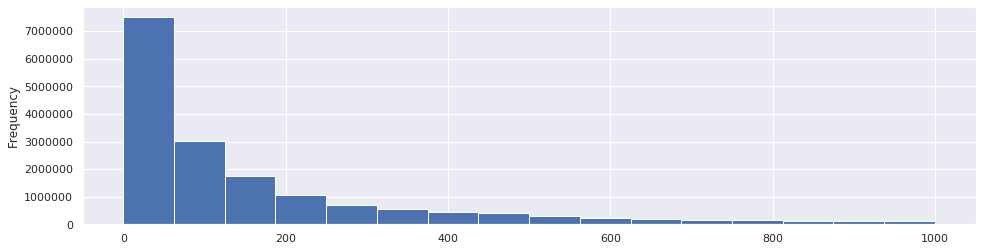

In [21]:
# Label distribution
me = meter[(meter.meter_reading > 0) & (meter.meter_reading <= 1000)]
me.meter_reading.plot(kind='hist', bins=16);

In [22]:
# Inspect high meter readings
mre6 = meter[meter.meter_reading >= 1e6]
mre6

,building_id,meter,timestamp,meter_reading,site_id
1534,1099,2,2016-01-01 00:00:00,3241630.0,13
3830,1099,2,2016-01-01 01:00:00,3241630.0,13
13015,1099,2,2016-01-01 05:00:00,1896620.0,13
22191,1099,2,2016-01-01 09:00:00,3554740.0,13
24488,1099,2,2016-01-01 10:00:00,3341210.0,13
...,...,...,...,...,...
17376197,1099,2,2016-11-11 04:00:00,1069800.0,13
17404294,1099,2,2016-11-11 16:00:00,1228510.0,13
17418080,1099,2,2016-11-11 22:00:00,2378950.0,13
17420378,1099,2,2016-11-11 23:00:00,17447600.0,13


In [23]:
# Check these buildings and meters
print('Buildings:', mre6.building_id.unique())
print('Meters:', mre6.meter.unique())

Buildings: [1099]
Meters: [2]


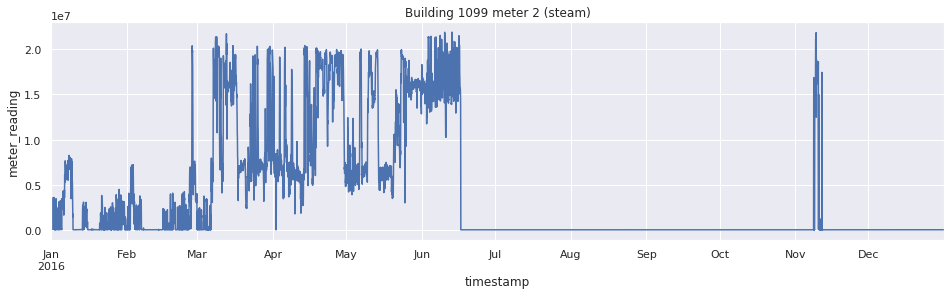

In [24]:
b1099m2 = meter[(meter.building_id == 1099) & (meter.meter == 2)].set_index('timestamp')
b1099m2.meter_reading.plot(title='Building 1099 meter 2 (steam)')
plt.ylabel('meter_reading');

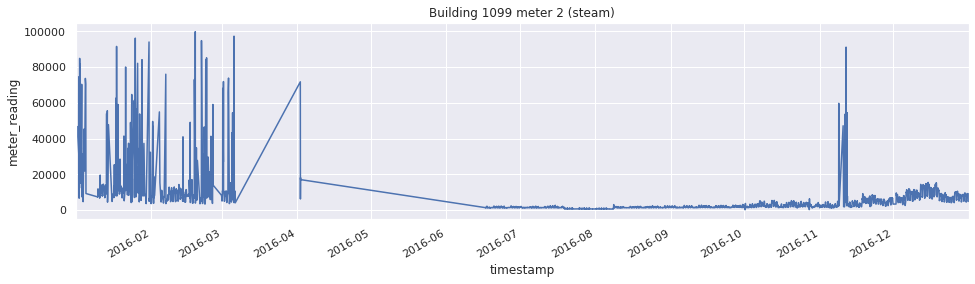

In [25]:
# Set max to 10,000
b1099m2[b1099m2.meter_reading <= 1e5].meter_reading.plot(title='Building 1099 meter 2 (steam)')
plt.ylabel('meter_reading');

In [26]:
# Outlier threshold
lower, upper = udf.calc_outlier_threshold(meter, 'meter_reading', stat='iqr', mult=50)
lower, upper

(-11390.863775253296, 11654.689975738525)

In [27]:
# Outlier count
total = meter.shape[0]
outliers = meter[meter.meter_reading > upper].shape[0]
print(f'{outliers} outliers')
print(f'{round(outliers * 100 / total, 2)}% outliers')

77229 outliers
0.38% outliers


In [28]:
# Remove outliers
meter = meter[meter.meter_reading <= upper]
meter.shape

(20138871, 5)

In [29]:
del timestamp_count, num_meters, num_timestamps, me, mre6, b1099m2, lower, upper, total, outliers
gc.collect()

11185

In [30]:
meter.head()

,building_id,meter,timestamp,meter_reading,site_id
0,0,0,2016-01-01,0.0,0
1,1,0,2016-01-01,0.0,0
2,2,0,2016-01-01,0.0,0
3,3,0,2016-01-01,0.0,0
4,4,0,2016-01-01,0.0,0


In [31]:
# Add meter type string in a new column
types = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}
meter['meter_type'] = meter.meter.map(types)

# How many buildings have a certain meter
meter_type_count = meter.groupby('meter_type').building_id.nunique().sort_values()
meter_type_count

meter_type
hotwater         145
steam            324
chilledwater     498
electricity     1413
Name: building_id, dtype: int64

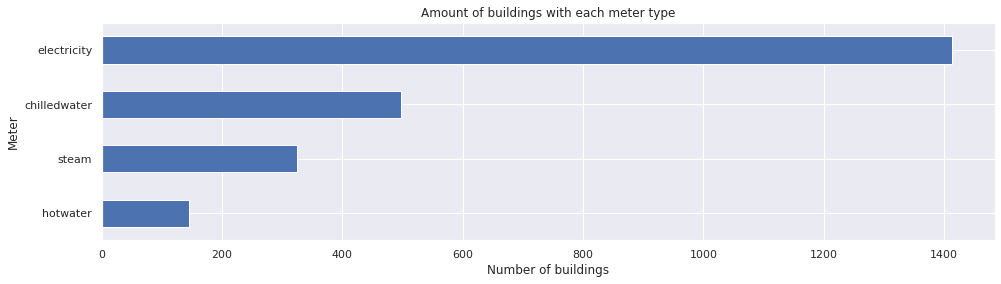

In [32]:
meter_type_count.plot.barh(title='Amount of buildings with each meter type')
plt.ylabel('Meter')
plt.xlabel('Number of buildings');

In [33]:
# How many buildings have a certain number of meters
meter_count = meter.groupby('building_id').meter.nunique().value_counts().sort_values()
meter_count

4     13
2    230
3    331
1    875
Name: meter, dtype: int64

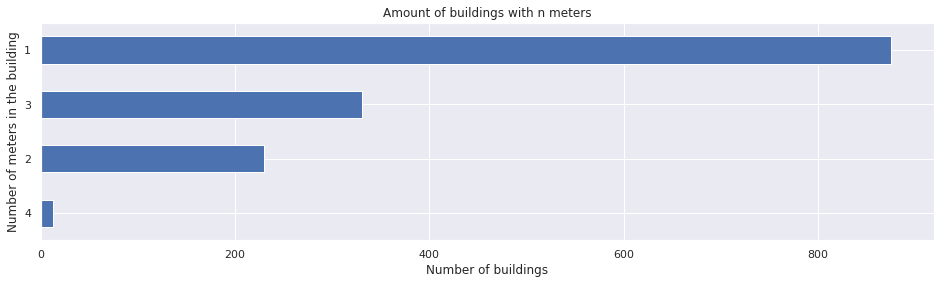

In [34]:
meter_count.plot.barh(title='Amount of buildings with n meters')
plt.ylabel('Number of meters in the building')
plt.xlabel('Number of buildings');

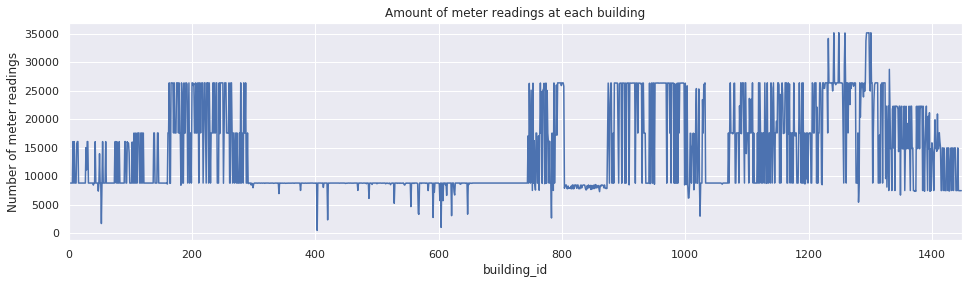

In [35]:
meter.groupby('building_id').timestamp.count().plot(title='Amount of meter readings at each building')
plt.ylabel('Number of meter readings');

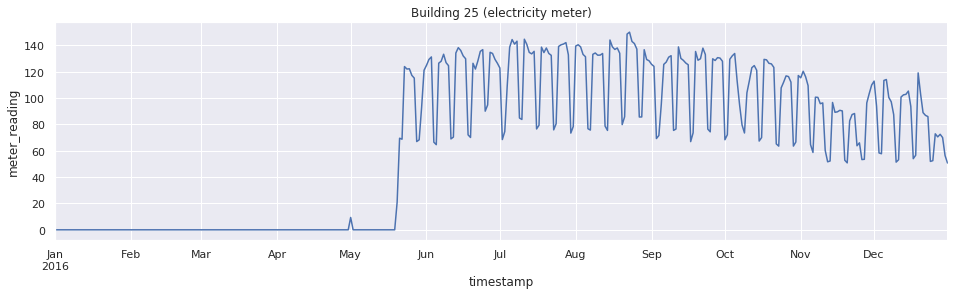

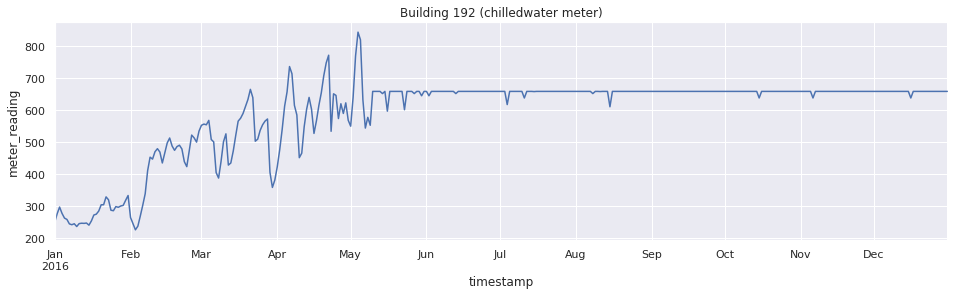

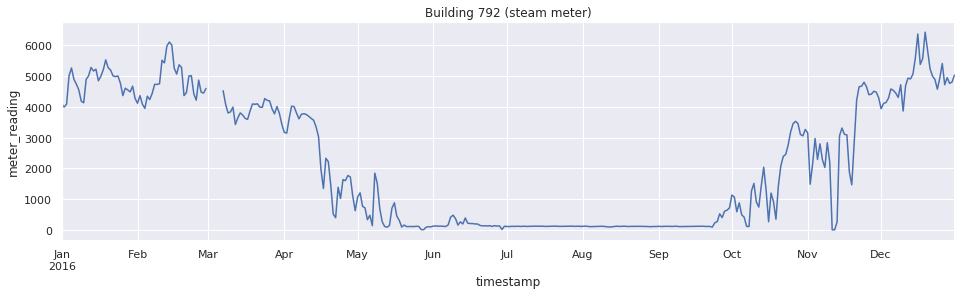

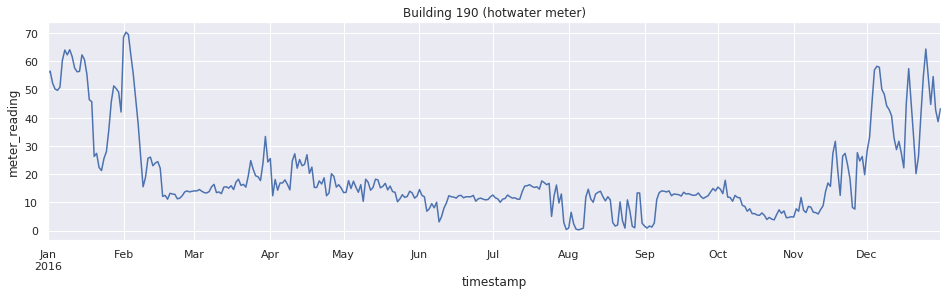

In [36]:
# Meter readings from each meter type
meter_groups = [meter[meter.meter == m].building_id.unique() for m in range(4)]
udf.plot_readings(meter, meter_groups, freq='d', start=25, end=26)

In [37]:
# Extract time components from timestamp
comps = ['dayofyear', 'month', 'day', 'dayofweek', 'hour']
meter = udf.extract_from_dt(meter, comps)
meter.head()

,building_id,meter,timestamp,meter_reading,site_id,meter_type,dayofyear,month,day,dayofweek,hour
0,0,0,2016-01-01,0.0,0,electricity,1,1,1,4,0
1,1,0,2016-01-01,0.0,0,electricity,1,1,1,4,0
2,2,0,2016-01-01,0.0,0,electricity,1,1,1,4,0
3,3,0,2016-01-01,0.0,0,electricity,1,1,1,4,0
4,4,0,2016-01-01,0.0,0,electricity,1,1,1,4,0


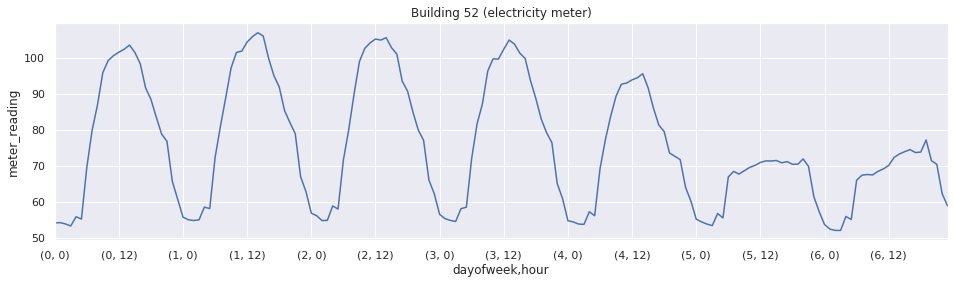

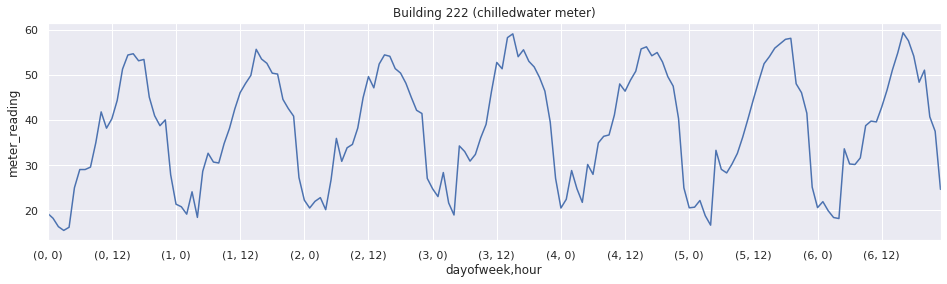

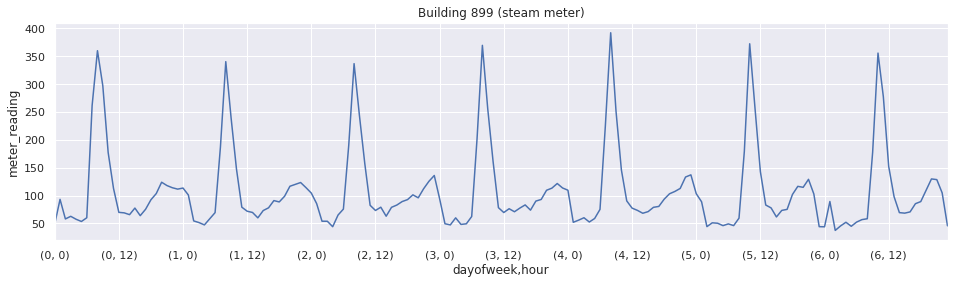

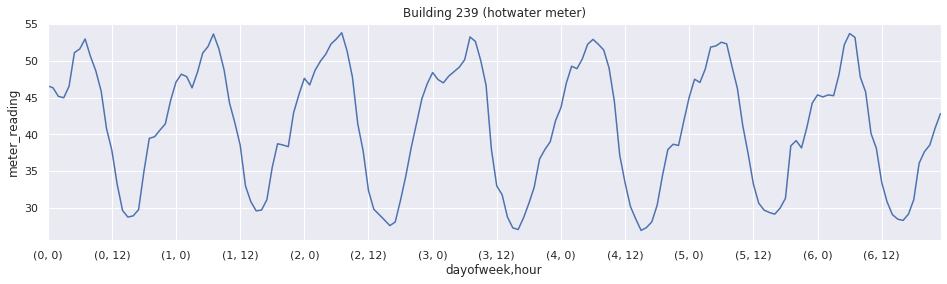

In [38]:
# Meter readings by weekday
udf.plot_readings(meter, meter_groups, group=['dayofweek', 'hour'], start=50, end=51, ticks=range(0, 7 * 24, 12))

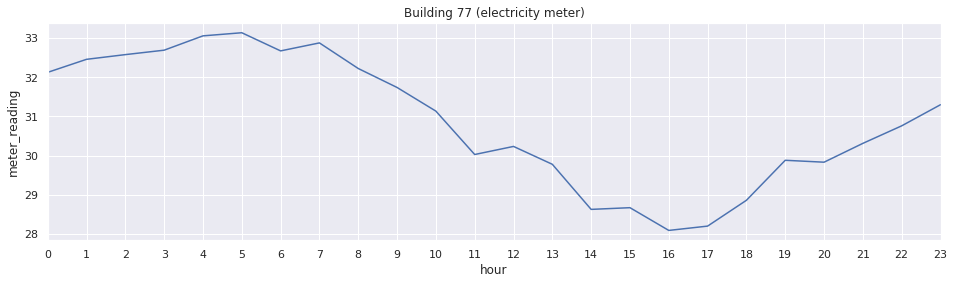

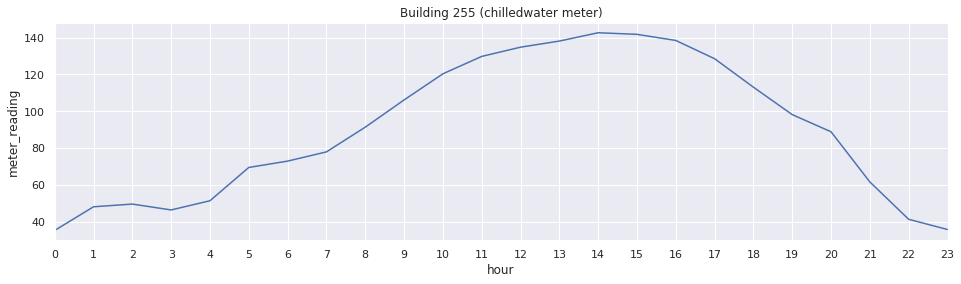

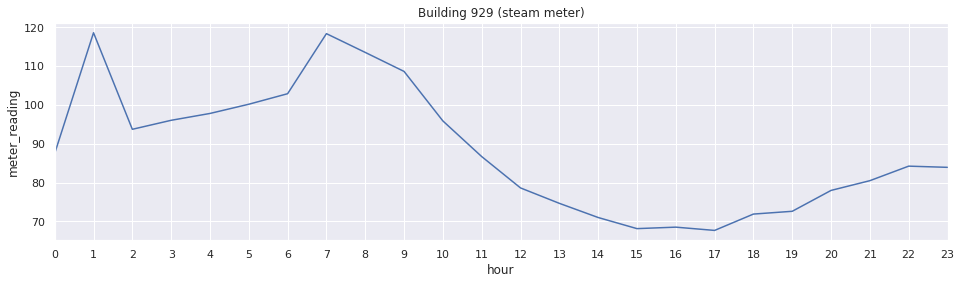

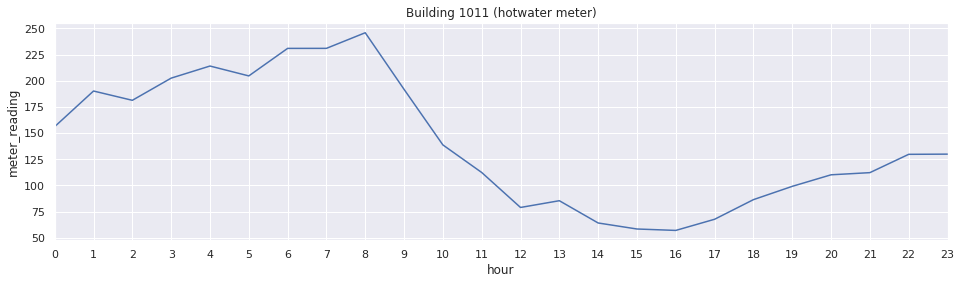

In [39]:
# Meter readings by hour
udf.plot_readings(meter, meter_groups, group=['hour'], start=75, end=76, ticks=range(24))

site_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
timestamp,,,,,,,,,,,,,,,,
2016-01-31,0.302356,165.237976,150.978973,128.926010,178.021454,35.800755,183.470703,2028.532227,67.998383,166.964554,85.023293,226.224060,104.323204,207.169144,189.406540,136.978394
2016-02-29,0.263162,172.673386,154.542572,131.194321,191.487045,34.987667,190.008514,2054.196777,62.603138,186.900696,84.666573,218.125427,102.265030,213.792877,194.409653,147.705246
2016-03-31,0.142274,165.321304,150.074158,115.740570,184.133942,33.401417,182.101440,2036.989990,64.803032,187.020294,84.062660,216.506912,97.240211,208.483887,188.803268,132.735153
2016-04-30,0.119945,161.678024,153.533066,106.219467,189.188812,31.260864,180.566010,2003.126343,62.214172,186.891541,87.247047,207.659500,104.171745,216.380829,192.296951,139.363144
2016-05-31,36.974598,164.861023,146.106766,114.830704,180.759552,29.691902,174.925262,1961.935059,63.549713,177.398743,71.717094,227.222794,95.400681,238.978271,187.323105,134.076172
2016-06-30,104.027199,164.456253,153.395264,137.606674,182.773010,29.646326,166.725220,1960.933472,72.146263,177.121231,80.293541,291.615387,93.924194,275.580475,189.259781,127.164536
2016-07-31,107.820717,162.073563,158.442505,150.189255,179.688385,27.776926,169.664612,1945.118896,70.718506,171.247452,79.566040,324.269531,95.532089,298.500549,180.073242,133.730881
2016-08-31,108.591232,160.943573,162.553436,157.496765,179.188354,24.575287,168.826797,1816.260010,60.110844,186.839447,79.725739,326.542603,95.274162,312.610748,188.691040,139.053497
2016-09-30,113.165001,160.172440,160.332153,143.834915,182.720093,30.774191,175.038467,2150.535156,70.592590,197.631424,78.011269,300.466858,100.723297,275.325806,194.195831,141.753357


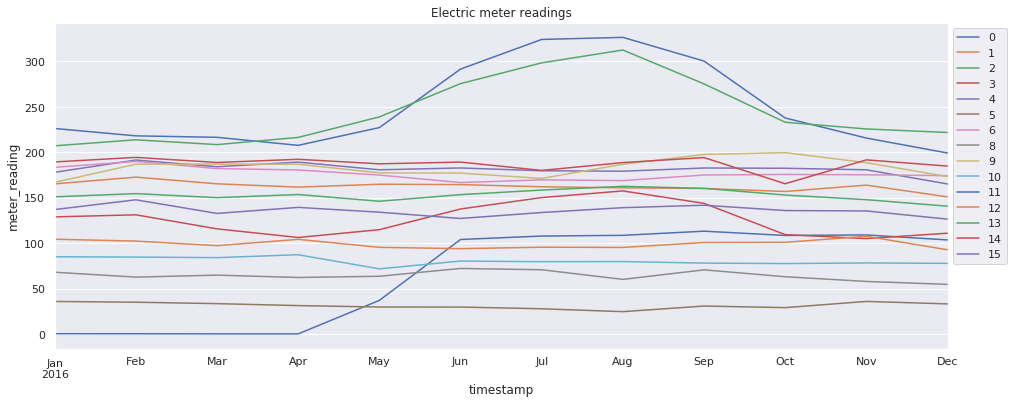

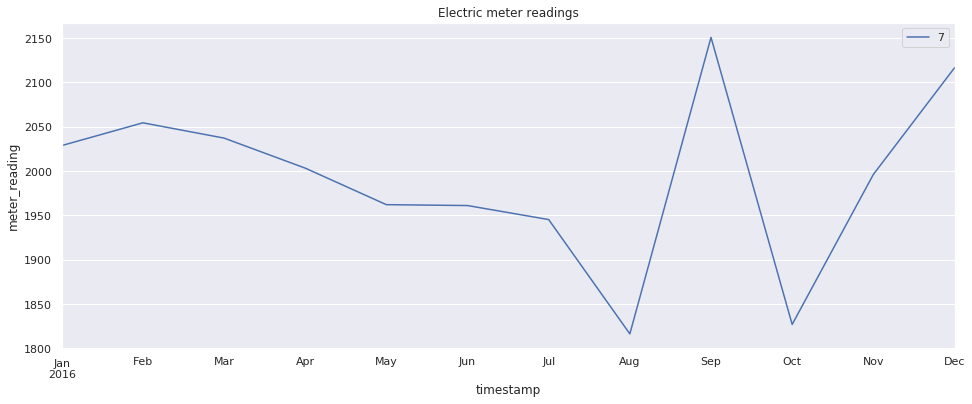

In [40]:
# Electric meters only
e_meter = meter[meter.meter == 0]

# Electric meter readings by site (readings from site 7 are on a higher scale)
udf.show_elec_readings(e_meter, by='site_id', freq='m', cols_to_sep=[7])

In [41]:
del types, meter_type_count, meter_count, meter_groups, comps, e_meter
gc.collect()

23416

### EDA - Weather

In [42]:
weather.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.0,NaN,1019.700012,0.0,0.0
1,0,2016-01-01 01:00:00,24.400000,NaN,21.1,-1.0,1020.200012,70.0,1.5
2,0,2016-01-01 02:00:00,22.799999,2.0,21.1,0.0,1020.200012,0.0,0.0
3,0,2016-01-01 03:00:00,21.100000,2.0,20.6,0.0,1020.099976,0.0,0.0
4,0,2016-01-01 04:00:00,20.000000,2.0,20.0,-1.0,1020.000000,250.0,2.6


In [43]:
weather.describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,139773.000000,139718.000000,70600.000000,139660.000000,89484.000000,129155.000000,133505.000000,139469.000000
mean,7.478977,14.418107,2.149306,7.350158,0.983047,1016.158081,180.526627,3.560527
std,4.604744,10.626595,2.599150,9.790235,8.463677,7.629684,111.523628,2.335874
min,0.000000,-28.900000,0.000000,-35.000000,-1.000000,968.200012,0.000000,0.000000
25%,3.000000,7.200000,0.000000,0.600000,0.000000,1011.799988,80.000000,2.100000
50%,7.000000,15.000000,2.000000,8.300000,0.000000,1016.400024,190.000000,3.100000
75%,11.000000,22.200001,4.000000,14.400000,0.000000,1020.799988,280.000000,5.000000
max,15.000000,47.200001,9.000000,26.100000,343.000000,1045.500000,360.000000,19.000000


In [44]:
# Duplicated observations
weather.duplicated(subset=['site_id', 'timestamp']).sum()

0

In [45]:
# Missing values
weather.isnull().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

In [46]:
# Missing timestamps
(16 * 366 * 24) - weather.shape[0]

771

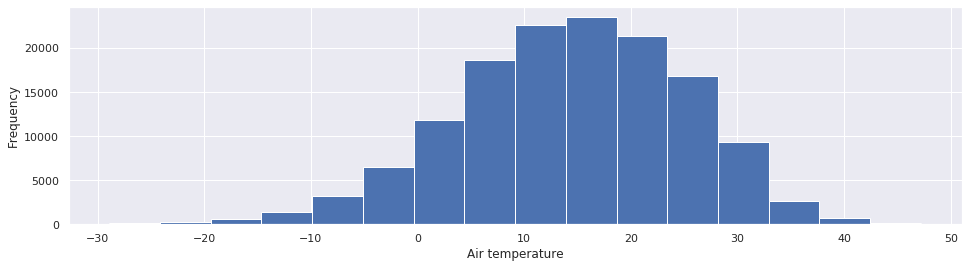

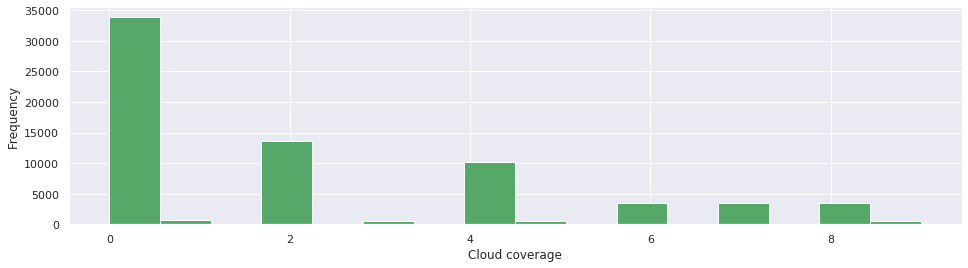

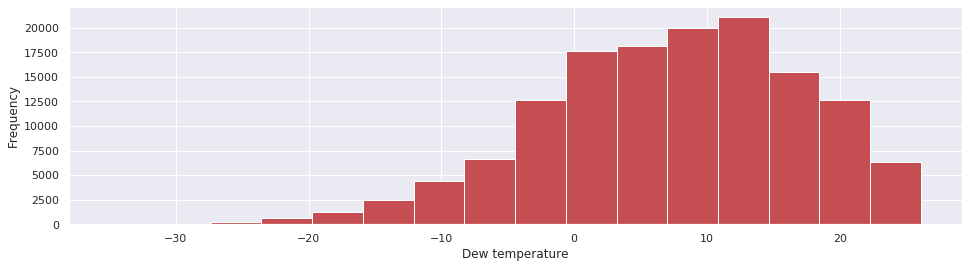

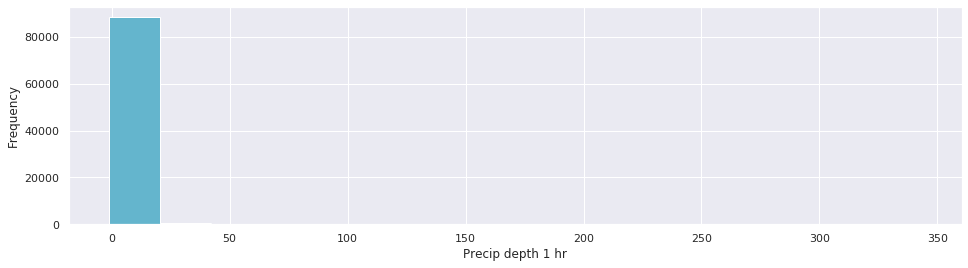

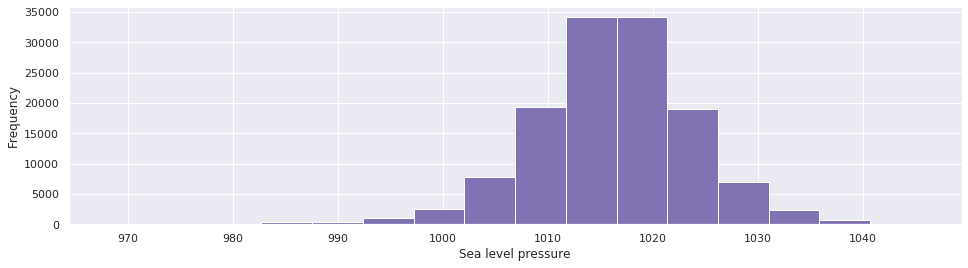

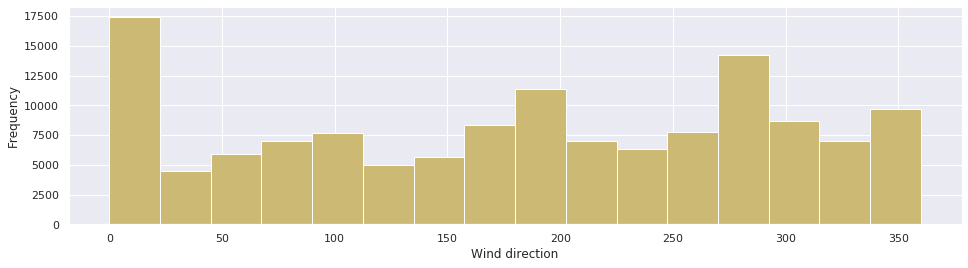

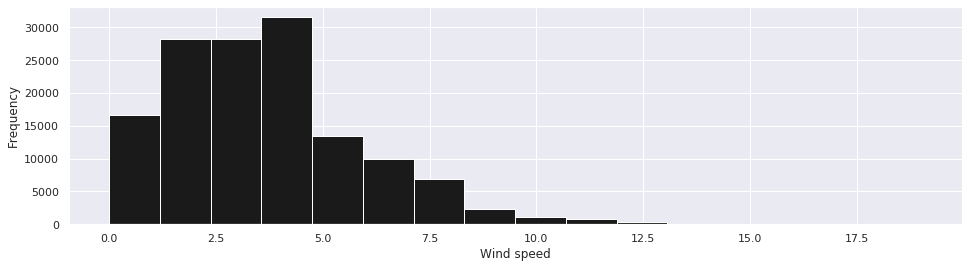

In [47]:
# Value distributions
udf.plot_dist(weather, range(2,9))

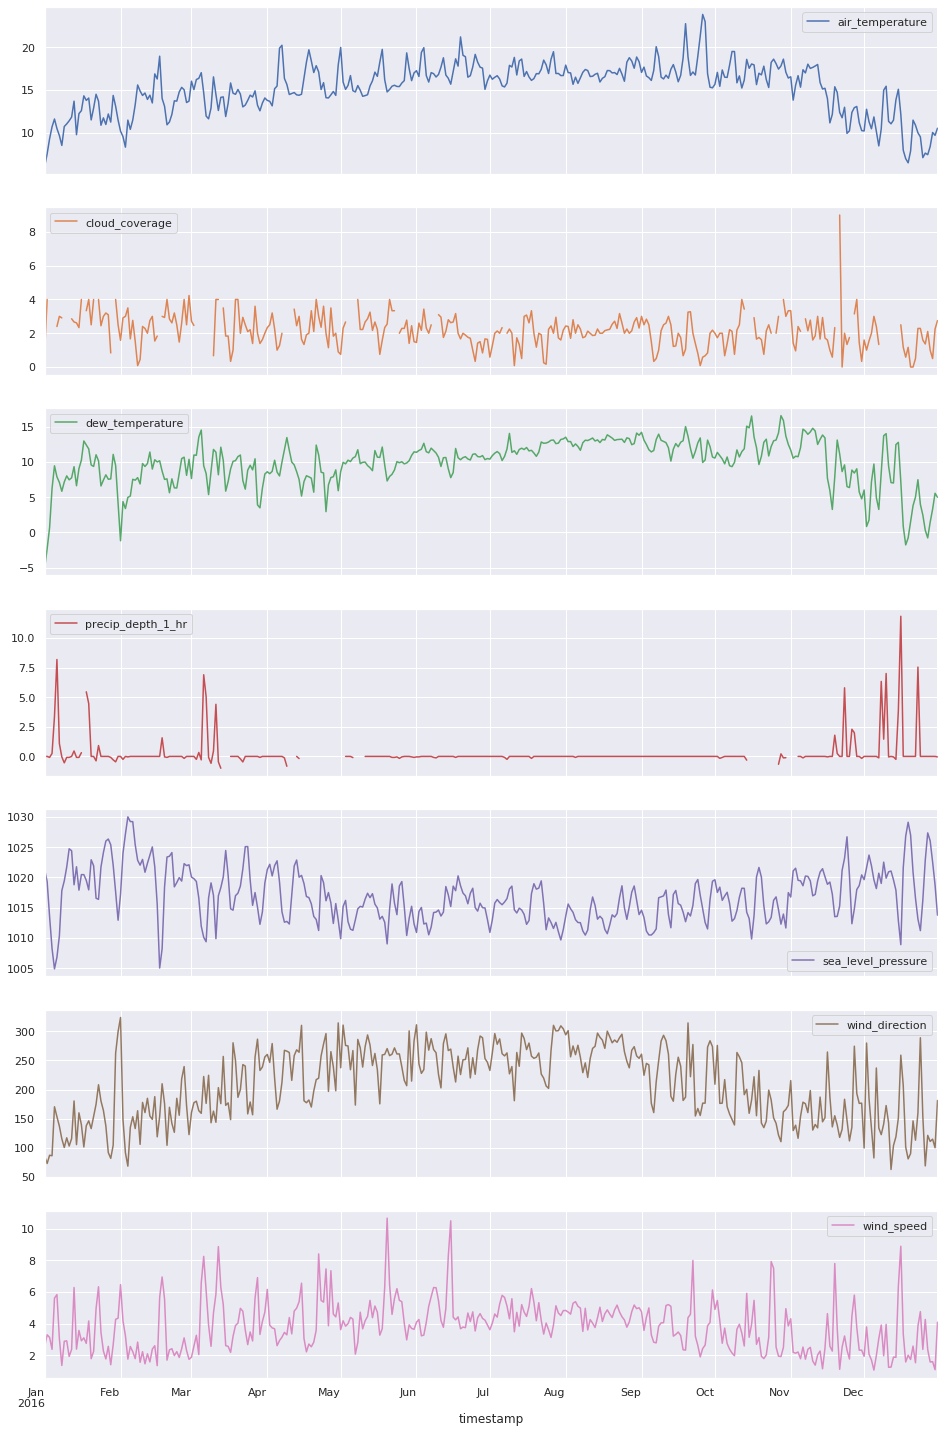

In [48]:
# Daily weather in site 4
weather4 = udf.get_site(weather, 4, time_idx=True).resample('d').mean()
weather4.plot(subplots=True, figsize=(16, 28))
plt.xticks(rotation=0);

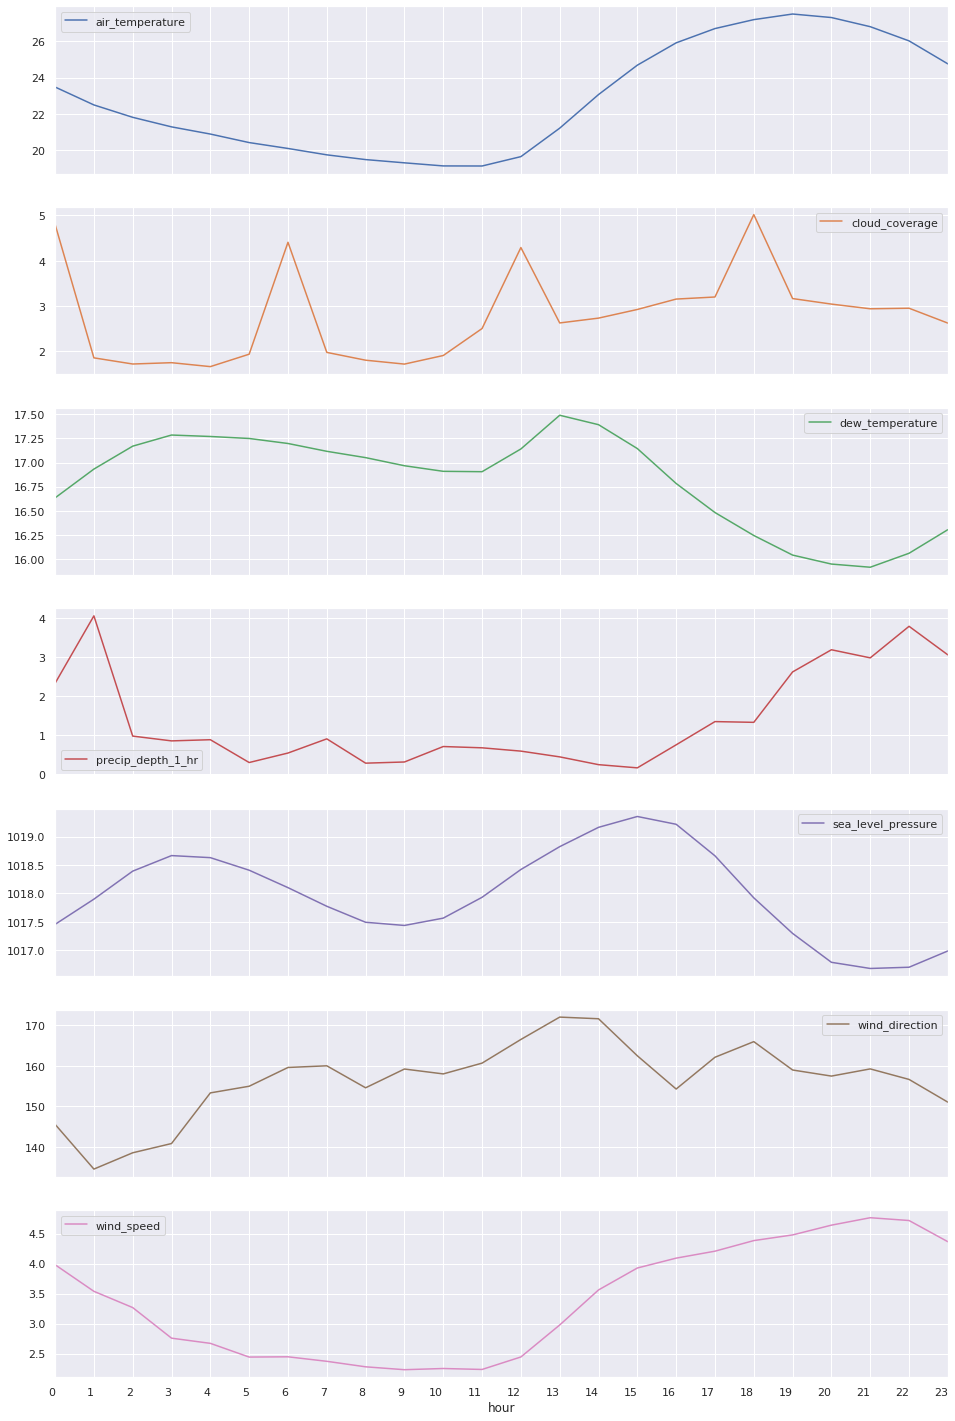

In [52]:
# Extract hour from timestamp
weather = udf.extract_from_dt(weather, ['hour'])

# Site 8 hourly weather
weather8 = udf.get_site(weather, 8).groupby('hour').mean()
weather8.plot(subplots=True, figsize=(16, 28))
plt.xticks(range(24), rotation=0);

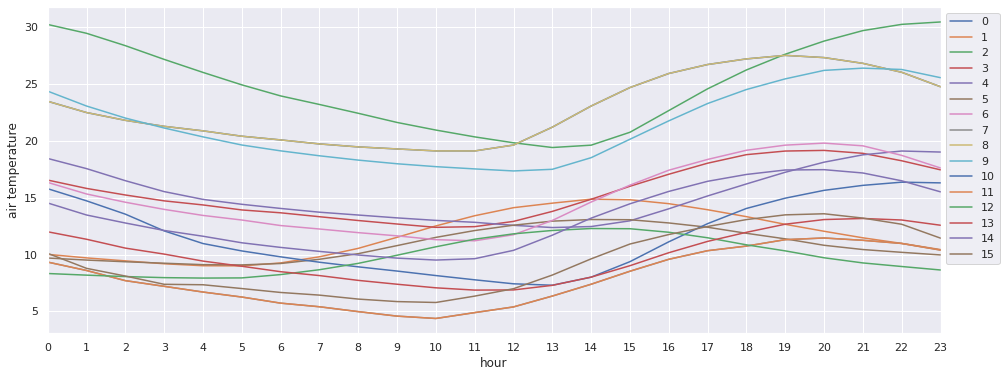

In [53]:
airtemp = pd.pivot_table(weather, index='hour', columns='site_id', values='air_temperature', aggfunc='mean')
airtemp.plot(figsize=(16, 6), xticks=range(24), title='Hourly air temperature by site')
plt.ylabel('air temperature')
plt.legend(bbox_to_anchor=(1, 1), fancybox=True);

Sites:
- 0 - Orlando, Florida (GMT-5)
- 1 - United Kingdom (GMT+0)
- 2 - Arizona (GMT-7)
- 3 - U.S. Eastern Time Zone (GMT-5)
- 4 - Northern California (GMT-8)
- 5 - United Kingdom (GMT+0)
- 6 - U.S. Eastern Time Zone (GMT-5)
- 7 - Southeastern Canada (GMT-5)
- 8 - Orlando, Florida (GMT-5)
- 9 - Texas (GMT-6)
- 10 - U.S. Mountain Time Zone (GMT-7)
- 11 - Southeastern Canada (GMT-5)
- 12 - Dublin, Ireland (GMT+0)
- 13 - Minnesota (GMT-6)
- 14 - U.S. Eastern Time Zone (GMT-5)
- 15 - U.S. Eastern Time Zone (GMT-5)

Sources:
- https://www.kaggle.com/c/ashrae-energy-prediction/discussion/115698
- https://www.kaggle.com/patrick0302/locate-cities-according-weather-temperature
- https://www.kaggle.com/datadugong/locate-better-cities-by-weather-temp-fill-nans

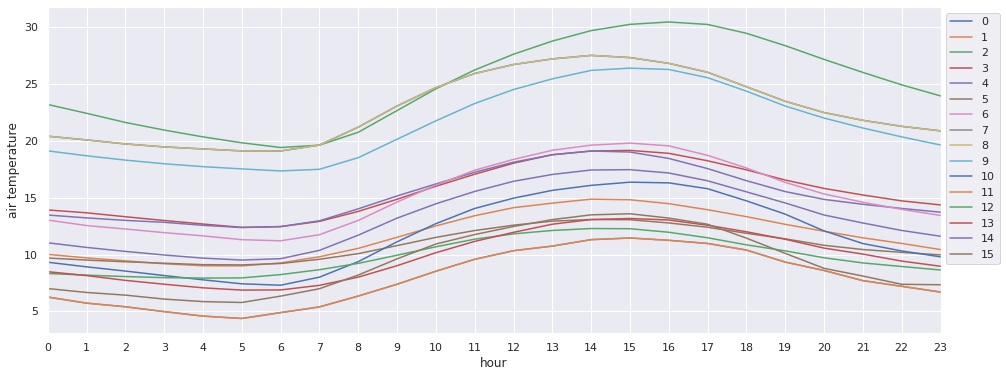

In [54]:
# Offsets for timezones
timezones = [-5, 0, -7, -5, -8, 0, -5, -5, -5, -6, -7, -5, 0, -6, -5, -5]

# Convert UTC to local time
weather = udf.to_local_time(weather, timezones)
weather['hour'] = weather.timestamp.dt.hour

airtemp = pd.pivot_table(weather, index='hour', columns='site_id', values='air_temperature', aggfunc='mean')
airtemp.plot(figsize=(16, 6), xticks=range(24), title='Hourly air temperature by site')
plt.ylabel('air temperature')
plt.legend(bbox_to_anchor=(1, 1), fancybox=True);

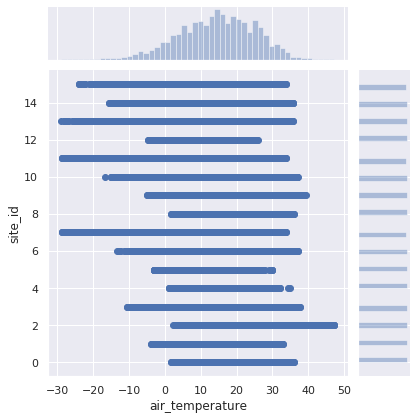

In [55]:
# Air temperature by site
sns.jointplot('air_temperature', 'site_id', data=weather);

In [56]:
del weather4, weather8, airtemp, timezones
gc.collect()

13410

### EDA - Building

In [57]:
building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [58]:
building.describe()

,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,675.000000,355.000000
mean,6.952381,724.000000,92111.776398,1967.957031,3.740845
std,5.003432,418.434583,110769.950997,31.054029,3.333683
min,0.000000,0.000000,283.000000,1900.000000,1.000000
25%,3.000000,362.000000,23012.000000,1949.000000,1.000000
50%,5.000000,724.000000,57673.000000,1970.000000,3.000000
75%,13.000000,1086.000000,115676.000000,1995.000000,5.000000
max,15.000000,1448.000000,875000.000000,2017.000000,26.000000


In [59]:
# Duplicated observations
building.duplicated(subset=['building_id']).sum()

0

In [60]:
# Missing values
building.isnull().sum()

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

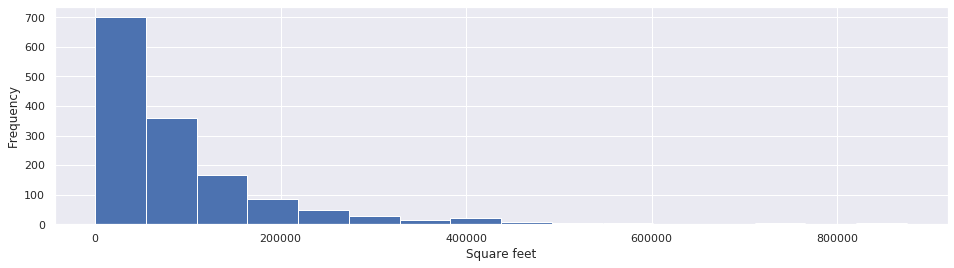

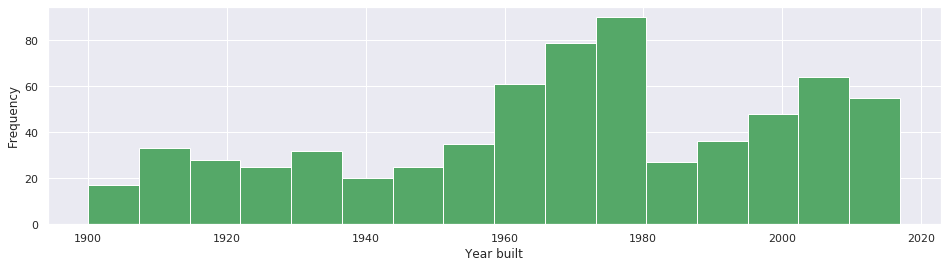

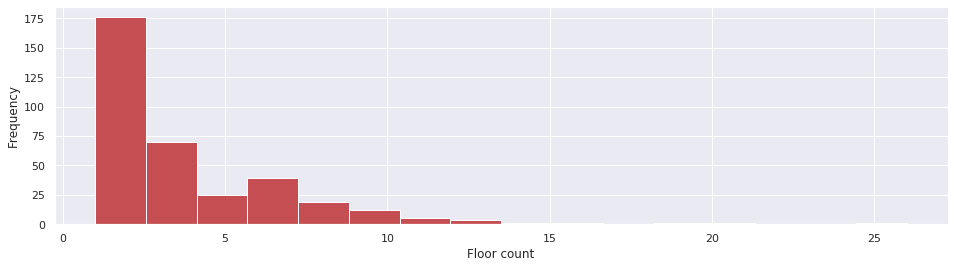

In [61]:
udf.plot_dist(building, range(3, 6))

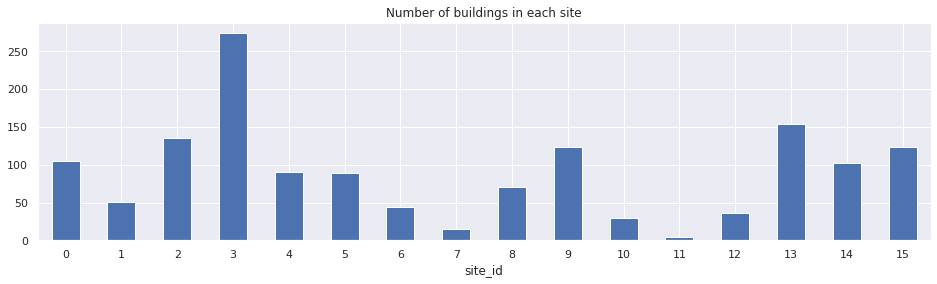

In [62]:
building.groupby('site_id').building_id.count().plot.bar(title='Number of buildings in each site')
plt.xticks(rotation=0);

In [63]:
# Mean values by site
avgbysite = building.drop('building_id', axis=1).groupby('site_id').mean()
avgbysite

,square_feet,year_built,floor_count
site_id,,,
0,86394.638095,1995.542847,NaN
1,65002.392157,1961.474976,7.000000
2,99542.214815,1974.882935,NaN
3,75290.383212,1961.727295,NaN
4,92876.241758,1954.123535,5.252747
5,47612.415730,1962.602295,2.280899
6,91857.704545,NaN,NaN
7,323634.533333,1958.500000,8.733334
8,29712.200000,NaN,1.014286


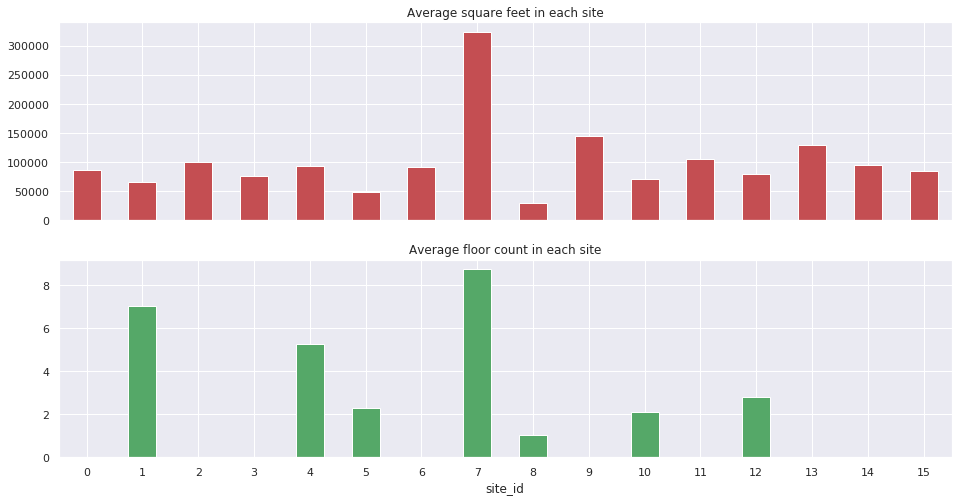

In [64]:
titles = ['Average %s in each site' % col for col in ['square feet', 'floor count']]
avgbysite.drop('year_built', axis=1).plot.bar(subplots=True, figsize=(16, 8), title=titles, legend=False, color=['r', 'g'])
plt.xticks(rotation=0);

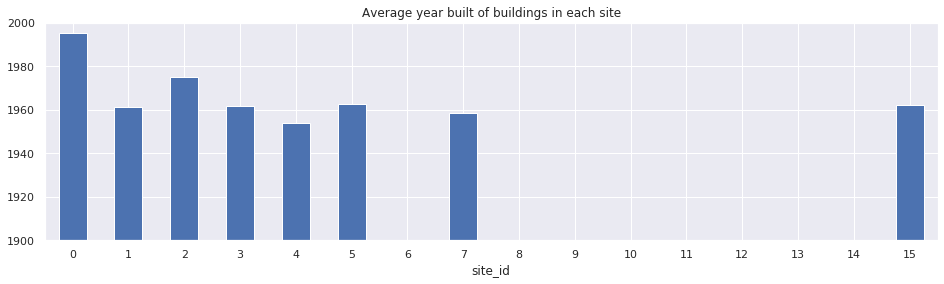

In [65]:
avgbysite.year_built.plot.bar(title='Average year built of buildings in each site', ylim=(1900, 2000))
plt.xticks(rotation=0);

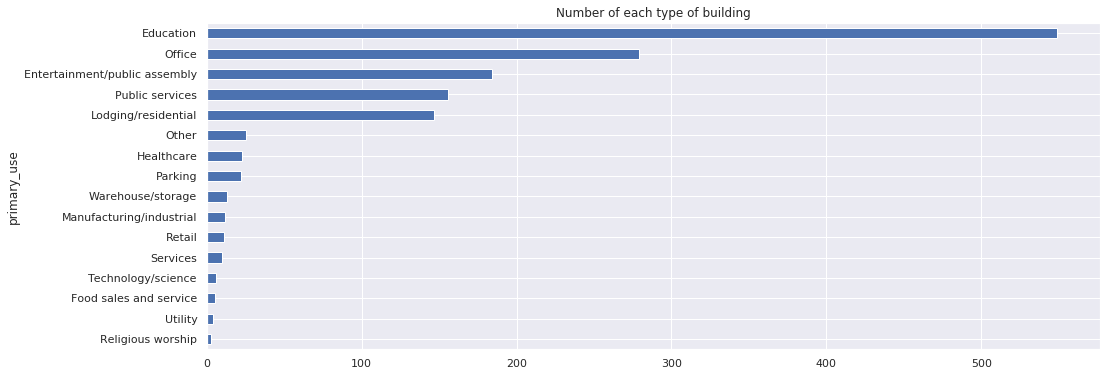

In [66]:
building.groupby('primary_use').building_id.count().sort_values().plot.barh(figsize=(16, 6), title='Number of each type of building');

In [67]:
usebysite = pd.pivot_table(building, index='site_id', columns='primary_use', values='building_id', aggfunc='count', fill_value=0)
usebysite

primary_use,Education,Entertainment/public assembly,Food sales and service,Healthcare,Lodging/residential,Manufacturing/industrial,Office,Other,Parking,Public services,Religious worship,Retail,Services,Technology/science,Utility,Warehouse/storage
site_id,,,,,,,,,,,,,,,,
0,30,5,0,0,27,0,24,5,8,0,0,6,0,0,0,0
1,22,1,0,0,10,0,16,0,0,2,0,0,0,0,0,0
2,61,21,2,1,12,0,24,0,3,6,1,1,0,0,1,2
3,92,44,0,6,11,0,23,4,1,86,1,1,0,0,0,5
4,66,9,0,0,4,0,0,0,3,6,0,0,0,2,1,0
5,49,18,0,1,1,3,11,1,0,5,0,0,0,0,0,0
6,15,4,0,0,12,0,11,0,0,2,0,0,0,0,0,0
7,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,24,0,0,0,0,7,9,0,28,0,0,0,0,0,2


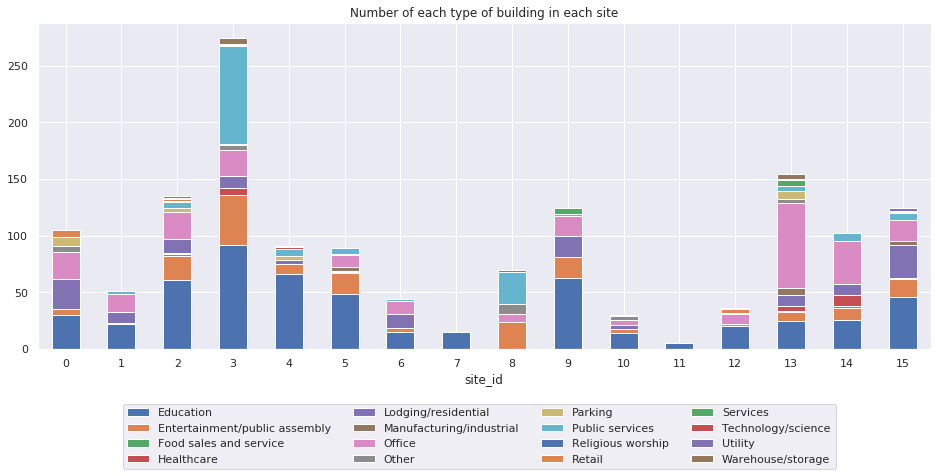

In [68]:
usebysite.plot.bar(stacked=True, figsize=(16, 6), title='Number of each type of building in each site')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(0.9, -0.15), ncol=4, fancybox=True);

In [69]:
# Mean values by primary use
avgbyuse = building.drop(['site_id', 'building_id'], axis=1).groupby('primary_use').mean()
avgbyuse

,square_feet,year_built,floor_count
primary_use,,,
Education,104329.000000,1962.579712,4.732558
Entertainment/public assembly,80584.070652,1970.904053,2.089286
Food sales and service,38485.000000,2012.000000,NaN
Healthcare,140480.869565,1982.250000,1.000000
Lodging/residential,85368.605442,1973.282349,6.333333
Manufacturing/industrial,41120.833333,1957.666626,1.666667
Office,87065.627240,1972.894165,3.725000
Other,31456.560000,1981.500000,1.076923
Parking,279341.772727,1998.500000,2.666667


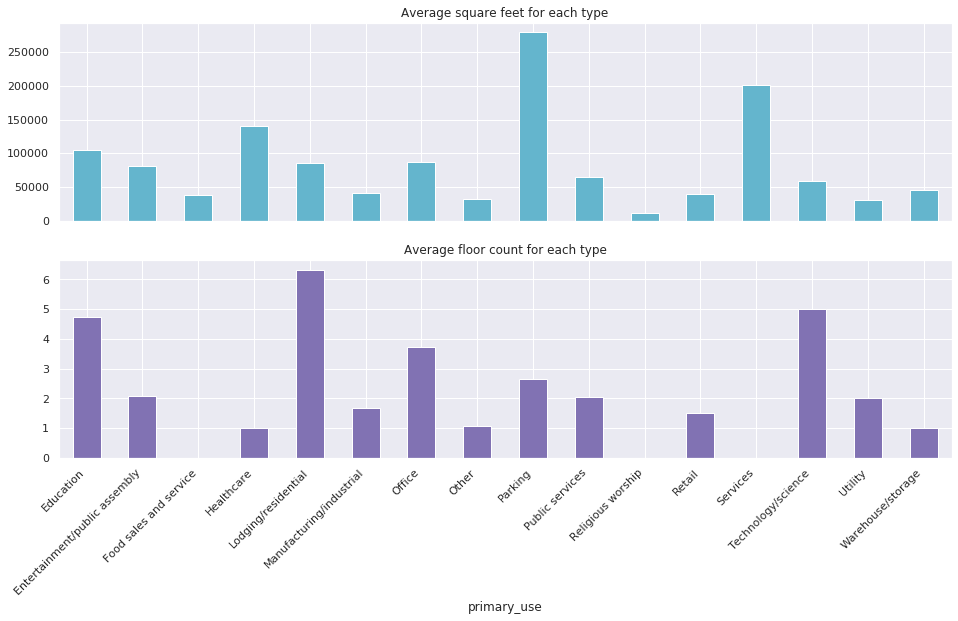

In [70]:
# Subplot titles
titles = ['Average %s for each type' % col for col in ['square feet', 'floor count']]

# Average square_feet and floor_count
avgbyuse.drop('year_built', axis=1).plot.bar(subplots=True, figsize=(16, 8), title=titles, legend=False, color=['c', 'm'])
plt.xticks(rotation=45, ha='right');

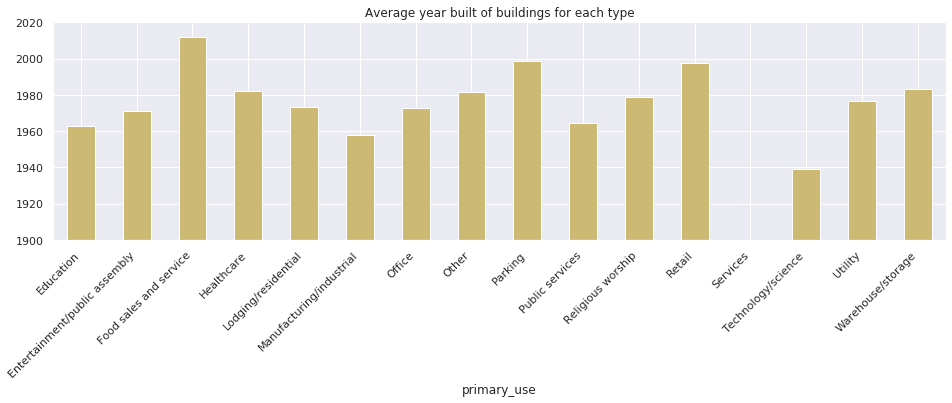

In [71]:
# Average year_built
avgbyuse.year_built.plot.bar(figsize=(16, 4), title='Average year built of buildings for each type', ylim=(1900, 2020), color='y')
plt.xticks(rotation=45, ha='right');

In [72]:
del avgbysite, titles, usebysite, avgbyuse
gc.collect()

32980

### Save dataframes

In [73]:
meter.head()

,building_id,meter,timestamp,meter_reading,site_id,meter_type,dayofyear,month,day,dayofweek,hour
0,0,0,2016-01-01,0.0,0,electricity,1,1,1,4,0
1,1,0,2016-01-01,0.0,0,electricity,1,1,1,4,0
2,2,0,2016-01-01,0.0,0,electricity,1,1,1,4,0
3,3,0,2016-01-01,0.0,0,electricity,1,1,1,4,0
4,4,0,2016-01-01,0.0,0,electricity,1,1,1,4,0


In [74]:
weather.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour
0,0,2015-12-31 19:00:00,25.000000,6.0,20.0,NaN,1019.700012,0.0,0.0,19
1,0,2015-12-31 20:00:00,24.400000,NaN,21.1,-1.0,1020.200012,70.0,1.5,20
2,0,2015-12-31 21:00:00,22.799999,2.0,21.1,0.0,1020.200012,0.0,0.0,21
3,0,2015-12-31 22:00:00,21.100000,2.0,20.6,0.0,1020.099976,0.0,0.0,22
4,0,2015-12-31 23:00:00,20.000000,2.0,20.0,-1.0,1020.000000,250.0,2.6,23


In [75]:
building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [76]:
path = '../data/from_eda/'

# Meter and weather dataframes were changed
meter.to_csv(f'{path}meter.csv', index=False)
weather.to_csv(f'{path}weather.csv', index=False)

In [77]:
meter = pd.read_csv(f'{path}meter.csv', parse_dates=['timestamp'])
meter.head()

,building_id,meter,timestamp,meter_reading,site_id,meter_type,dayofyear,month,day,dayofweek,hour
0,0,0,2016-01-01,0.0,0,electricity,1,1,1,4,0
1,1,0,2016-01-01,0.0,0,electricity,1,1,1,4,0
2,2,0,2016-01-01,0.0,0,electricity,1,1,1,4,0
3,3,0,2016-01-01,0.0,0,electricity,1,1,1,4,0
4,4,0,2016-01-01,0.0,0,electricity,1,1,1,4,0


In [78]:
weather = pd.read_csv(f'{path}weather.csv', parse_dates=['timestamp'])
weather.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour
0,0,2015-12-31 19:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,19
1,0,2015-12-31 20:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5,20
2,0,2015-12-31 21:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0,21
3,0,2015-12-31 22:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0,22
4,0,2015-12-31 23:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,23
